In [190]:
import numpy as np
import cv2
import scipy
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data_utils import *
from redbox import *
import tqdm


In [191]:
data = load_formatted_data()

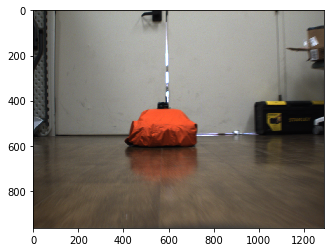

In [192]:
img = cv2.cvtColor(get_image(5,data),cv2.COLOR_BGR2RGB)
plt.imshow(img)

(416, 493)
(724, 600)


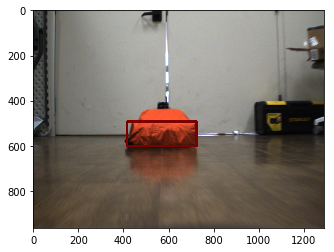

In [193]:
fin,x,y = frame_to_bounding_box(img,'rgb')
print(x)
print(y)
plt.imshow(img)

In [194]:
imgs = data[:,3]
img_bbox = []
for img in imgs:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = frame_to_bounding_box(img, 'rgb')
    img_bbox.append((img[1], img[2]))
img_bbox = np.array(img_bbox)
shp = img_bbox.shape
img_bbox = img_bbox.reshape((shp[0],shp[1]*shp[2]))
print(img_bbox.shape)

(367, 4)


In [195]:
def get_training(data,bbox,i):
    gtruth = np.array(get_hedge(i,data))
    lidar = np.hstack(get_lidar(i,data))
    for j in range(lidar.shape[0]):
        if lidar[j] == float('inf'):
            lidar[j] = 0
        elif lidar[j] == -float('inf'):
            lidar[j] = 0
            
    
    gtruth = gtruth.astype(float)
    boxi = bbox[i,:]
    training_moment = torch.from_numpy(np.hstack((boxi,lidar))).float()
    training_var = Variable(training_moment,requires_grad=True)
    gtruth = torch.from_numpy(gtruth).float()
    gtruth_var = Variable(gtruth,requires_grad=False)
    return training_var,gtruth_var
        

In [196]:
lid = get_lidar(2,data)
stacked = np.hstack(lid)
lidx = np.array(lid[0])
print(stacked.shape,lidx.shape)

(720,) (360,)


In [197]:
training_var,gtruth_var = get_training(data,img_bbox,1)
#print(gtruth_var,training_var)
inShp = training_var.shape
outShp = gtruth_var.shape
print(inShp,outShp)

torch.Size([724]) torch.Size([2])


In [198]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        #self.conv1 = nn.Conv2
        self.fc1 = nn.Linear(724, 40)
        self.fc2 = nn.Linear(40,2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    

In [199]:
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=724, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=2, bias=True)
)


In [200]:
loss_fn = nn.MSELoss()
inputs = Variable(torch.randn(inShp))
out = net.forward(inputs)
params = list(net.parameters())
loss = loss_fn(out,gtruth_var)
print(len(params))
print(out)
print(loss)


4
Variable containing:
 0.1054
-0.3357
[torch.FloatTensor of size 2]

Variable containing:
 2.8837
[torch.FloatTensor of size 1]



In [201]:
net.zero_grad()
out.backward(torch.randn(2))

In [202]:
optimizer = torch.optim.SGD(net.parameters(),lr=0.01,momentum=0.9)
n_epochs = 5
samples = data.shape[0]
validate_n = 100
n_max = samples - validate_n
losses = []


In [203]:
for epoch in tqdm.tqdm(range(n_epochs)):# loop over the dataset multiple times
    #print('epoch',epoch)
    for i in range(n_max):
        # get the inputs
        training_var,gtruth_var = get_training(data,img_bbox,i)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(training_var)
        loss = loss_fn(outputs, gtruth_var)
        #if loss.data.numpy() != float('inf'):
        loss.backward()
        optimizer.step()
        losses.append(loss.data.numpy())
        print(outputs,gtruth_var)
        

print('Finished Training')

  0%|          | 0/5 [00:00<?, ?it/s]

Variable containing:
 -8.7145
 17.4674
[torch.FloatTensor of size 2]
 Variable containing:
-2.2524
 0.1210
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+05 *
  1.0258
 -2.7222
[torch.FloatTensor of size 2]
 Variable containing:
-2.2524
 0.1210
[torch.FloatTensor of size 2]

Variable containing:
-1025.5034
 2721.9817
[torch.FloatTensor of size 2]
 Variable containing:
-2.2524
 0.1210
[torch.FloatTensor of size 2]

Variable containing:
-1938.4185
 5144.5991
[torch.FloatTensor of size 2]
 Variable containing:
-2.2522
 0.1182
[torch.FloatTensor of size 2]

Variable containing:
-2740.6804
 7273.5103
[torch.FloatTensor of size 2]
 Variable containing:
-2.2522
 0.1182
[torch.FloatTensor of size 2]

Variable containing:
-3435.4006
 9116.8564
[torch.FloatTensor of size 2]
 Variable containing:
-2.2500
 0.1176
[torch.FloatTensor of size 2]

Variable containing:
 3.7122e+07
-1.0131e+08
[torch.FloatTensor of size 2]
 Variable containing:
-2.2500
 0.1176
[torch.FloatTensor of size 2]

 Variable containing:
-1.3057
-0.2386
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+05 *
  3.1144
 -8.4988
[torch.FloatTensor of size 2]
 Variable containing:
-1.3057
-0.2386
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+05 *
  3.0507
 -8.3250
[torch.FloatTensor of size 2]
 Variable containing:
-1.3026
-0.2653
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+05 *
  2.9629
 -8.0854
[torch.FloatTensor of size 2]
 Variable containing:
-1.3026
-0.2653
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+05 *
  2.8542
 -7.7888
[torch.FloatTensor of size 2]
 Variable containing:
-1.2759
-0.2622
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+05 *
  2.7278
 -7.4440
[torch.FloatTensor of size 2]
 Variable containing:
-1.2759
-0.2622
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+05 *
  2.5868
 -7.0593
[torch.FloatTensor of size 2]
 Variable containing:
-1.3065
-0.2712
[torch.FloatTensor of size 2]

Variable containing


Variable containing:
-5.3601e+16
 1.4624e+17
[torch.FloatTensor of size 2]
 Variable containing:
-1.8144
-0.3728
[torch.FloatTensor of size 2]

Variable containing:
-7.5781e+16
 2.0676e+17
[torch.FloatTensor of size 2]
 Variable containing:
-1.7782
-0.3861
[torch.FloatTensor of size 2]

Variable containing:
-9.4986e+16
 2.5916e+17
[torch.FloatTensor of size 2]
 Variable containing:
-1.8504
-0.4091
[torch.FloatTensor of size 2]

Variable containing:
-1.1132e+17
 3.0372e+17
[torch.FloatTensor of size 2]
 Variable containing:
-1.8504
-0.4091
[torch.FloatTensor of size 2]

Variable containing:
-1.2491e+17
 3.4079e+17
[torch.FloatTensor of size 2]
 Variable containing:
-1.8506
-0.4169
[torch.FloatTensor of size 2]

Variable containing:
-1.3589e+17
 3.7075e+17
[torch.FloatTensor of size 2]
 Variable containing:
-1.8506
-0.4169
[torch.FloatTensor of size 2]

Variable containing:
-1.4441e+17
 3.9400e+17
[torch.FloatTensor of size 2]
 Variable containing:
-1.8583
-0.4181
[torch.FloatTensor of 


Variable containing:
 1.3400e+16
-3.6560e+16
[torch.FloatTensor of size 2]
 Variable containing:
-1.5680
-0.2367
[torch.FloatTensor of size 2]

Variable containing:
 1.2068e+16
-3.2927e+16
[torch.FloatTensor of size 2]
 Variable containing:
-1.5680
-0.2367
[torch.FloatTensor of size 2]

Variable containing:
 1.0749e+16
-2.9328e+16
[torch.FloatTensor of size 2]
 Variable containing:
-1.7139
-0.1135
[torch.FloatTensor of size 2]

Variable containing:
 9.4546e+15
-2.5796e+16
[torch.FloatTensor of size 2]
 Variable containing:
-1.7139
-0.1135
[torch.FloatTensor of size 2]

Variable containing:
 8.1949e+15
-2.2359e+16
[torch.FloatTensor of size 2]
 Variable containing:
-1.8707
-0.0660
[torch.FloatTensor of size 2]

Variable containing:
 6.9792e+15
-1.9042e+16
[torch.FloatTensor of size 2]
 Variable containing:
-1.9859
-0.0591
[torch.FloatTensor of size 2]

Variable containing:
 5.8152e+15
-1.5866e+16
[torch.FloatTensor of size 2]
 Variable containing:
-1.9859
-0.0591
[torch.FloatTensor of 


Variable containing:
 5.4064e+14
-1.4751e+15
[torch.FloatTensor of size 2]
 Variable containing:
-3.0668
 0.6760
[torch.FloatTensor of size 2]

Variable containing:
 5.5472e+14
-1.5135e+15
[torch.FloatTensor of size 2]
 Variable containing:
-3.0457
 0.6107
[torch.FloatTensor of size 2]

Variable containing:
 5.6185e+14
-1.5329e+15
[torch.FloatTensor of size 2]
 Variable containing:
-3.0457
 0.6107
[torch.FloatTensor of size 2]

Variable containing:
 5.6264e+14
-1.5351e+15
[torch.FloatTensor of size 2]
 Variable containing:
-3.0457
 0.6107
[torch.FloatTensor of size 2]

Variable containing:
 5.5773e+14
-1.5217e+15
[torch.FloatTensor of size 2]
 Variable containing:
-2.9602
 0.2675
[torch.FloatTensor of size 2]

Variable containing:
 5.4774e+14
-1.4944e+15
[torch.FloatTensor of size 2]
 Variable containing:
-2.9602
 0.2675
[torch.FloatTensor of size 2]

Variable containing:
 5.3326e+14
-1.4549e+15
[torch.FloatTensor of size 2]
 Variable containing:
-2.9097
 0.0511
[torch.FloatTensor of 

 20%|██        | 1/5 [00:01<00:04,  1.15s/it]

Variable containing:
-7.7624e+13
 2.1179e+14
[torch.FloatTensor of size 2]
 Variable containing:
-2.2524
 0.1210
[torch.FloatTensor of size 2]

Variable containing:
-7.4147e+13
 2.0230e+14
[torch.FloatTensor of size 2]
 Variable containing:
-2.2524
 0.1210
[torch.FloatTensor of size 2]

Variable containing:
-7.0276e+13
 1.9174e+14
[torch.FloatTensor of size 2]
 Variable containing:
-2.2524
 0.1210
[torch.FloatTensor of size 2]

Variable containing:
-6.6090e+13
 1.8032e+14
[torch.FloatTensor of size 2]
 Variable containing:
-2.2522
 0.1182
[torch.FloatTensor of size 2]

Variable containing:
-6.1661e+13
 1.6823e+14
[torch.FloatTensor of size 2]
 Variable containing:
-2.2522
 0.1182
[torch.FloatTensor of size 2]

Variable containing:
-5.7058e+13
 1.5568e+14
[torch.FloatTensor of size 2]
 Variable containing:
-2.2500
 0.1176
[torch.FloatTensor of size 2]

Variable containing:
-5.2346e+13
 1.4282e+14
[torch.FloatTensor of size 2]
 Variable containing:
-2.2500
 0.1176
[torch.FloatTensor of s


Variable containing:
-7.3499e+11
 2.0053e+12
[torch.FloatTensor of size 2]
 Variable containing:
-1.3026
-0.2653
[torch.FloatTensor of size 2]

Variable containing:
-1.0130e+12
 2.7637e+12
[torch.FloatTensor of size 2]
 Variable containing:
-1.2759
-0.2622
[torch.FloatTensor of size 2]

Variable containing:
-1.2530e+12
 3.4187e+12
[torch.FloatTensor of size 2]
 Variable containing:
-1.2759
-0.2622
[torch.FloatTensor of size 2]

Variable containing:
-1.4565e+12
 3.9739e+12
[torch.FloatTensor of size 2]
 Variable containing:
-1.3065
-0.2712
[torch.FloatTensor of size 2]

Variable containing:
-1.6251e+12
 4.4339e+12
[torch.FloatTensor of size 2]
 Variable containing:
-1.3065
-0.2712
[torch.FloatTensor of size 2]

Variable containing:
-1.7606e+12
 4.8036e+12
[torch.FloatTensor of size 2]
 Variable containing:
-1.3024
-0.2015
[torch.FloatTensor of size 2]

Variable containing:
-1.8649e+12
 5.0883e+12
[torch.FloatTensor of size 2]
 Variable containing:
-1.3024
-0.2015
[torch.FloatTensor of 


Variable containing:
 1.6894e+11
-4.6093e+11
[torch.FloatTensor of size 2]
 Variable containing:
-1.8506
-0.4169
[torch.FloatTensor of size 2]

Variable containing:
 1.5189e+11
-4.1442e+11
[torch.FloatTensor of size 2]
 Variable containing:
-1.8506
-0.4169
[torch.FloatTensor of size 2]

Variable containing:
 1.3503e+11
-3.6842e+11
[torch.FloatTensor of size 2]
 Variable containing:
-1.8583
-0.4181
[torch.FloatTensor of size 2]

Variable containing:
 1.1851e+11
-3.2334e+11
[torch.FloatTensor of size 2]
 Variable containing:
-1.8597
-0.4182
[torch.FloatTensor of size 2]

Variable containing:
 1.0245e+11
-2.7953e+11
[torch.FloatTensor of size 2]
 Variable containing:
-1.8597
-0.4182
[torch.FloatTensor of size 2]

Variable containing:
 8.6976e+10
-2.3730e+11
[torch.FloatTensor of size 2]
 Variable containing:
-1.8597
-0.4182
[torch.FloatTensor of size 2]

Variable containing:
 7.2178e+10
-1.9693e+11
[torch.FloatTensor of size 2]
 Variable containing:
-1.8519
-0.4077
[torch.FloatTensor of 


Variable containing:
 6.9621e+09
-1.8995e+10
[torch.FloatTensor of size 2]
 Variable containing:
-1.8707
-0.0660
[torch.FloatTensor of size 2]

Variable containing:
 7.1277e+09
-1.9447e+10
[torch.FloatTensor of size 2]
 Variable containing:
-1.9859
-0.0591
[torch.FloatTensor of size 2]

Variable containing:
 7.2054e+09
-1.9659e+10
[torch.FloatTensor of size 2]
 Variable containing:
-1.9859
-0.0591
[torch.FloatTensor of size 2]

Variable containing:
 7.2033e+09
-1.9653e+10
[torch.FloatTensor of size 2]
 Variable containing:
-2.0463
-0.0339
[torch.FloatTensor of size 2]

Variable containing:
 7.1294e+09
-1.9452e+10
[torch.FloatTensor of size 2]
 Variable containing:
-2.0676
-0.0444
[torch.FloatTensor of size 2]

Variable containing:
 6.9916e+09
-1.9076e+10
[torch.FloatTensor of size 2]
 Variable containing:
-2.0676
-0.0444
[torch.FloatTensor of size 2]

Variable containing:
 6.7976e+09
-1.8546e+10
[torch.FloatTensor of size 2]
 Variable containing:
-2.0669
-0.0437
[torch.FloatTensor of 


Variable containing:
-2.0419e+08
 5.5711e+08
[torch.FloatTensor of size 2]
 Variable containing:
-2.9602
 0.2675
[torch.FloatTensor of size 2]

Variable containing:
-1.5713e+08
 4.2870e+08
[torch.FloatTensor of size 2]
 Variable containing:
-2.9602
 0.2675
[torch.FloatTensor of size 2]

Variable containing:
-1.1320e+08
 3.0884e+08
[torch.FloatTensor of size 2]
 Variable containing:
-2.9097
 0.0511
[torch.FloatTensor of size 2]

Variable containing:
-7.2526e+07
 1.9788e+08
[torch.FloatTensor of size 2]
 Variable containing:
-2.9097
 0.0511
[torch.FloatTensor of size 2]

Variable containing:
-3.5199e+07
 9.6037e+07
[torch.FloatTensor of size 2]
 Variable containing:
-2.9097
 0.0511
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+06 *
 -1.2526
  3.4182
[torch.FloatTensor of size 2]
 Variable containing:
-2.8403
-0.2060
[torch.FloatTensor of size 2]

Variable containing:
 2.9312e+07
-7.9973e+07
[torch.FloatTensor of size 2]
 Variable containing:
-2.8403
-0.2060
[torch.FloatTe

 40%|████      | 2/5 [00:02<00:03,  1.23s/it]

Variable containing:
 8.9788e+06
-2.4498e+07
[torch.FloatTensor of size 2]
 Variable containing:
-2.2524
 0.1210
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+06 *
  3.4548
 -9.4260
[torch.FloatTensor of size 2]
 Variable containing:
-2.2524
 0.1210
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+06 *
 -1.5514
  4.2328
[torch.FloatTensor of size 2]
 Variable containing:
-2.2524
 0.1210
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+07 *
 -0.6042
  1.6483
[torch.FloatTensor of size 2]
 Variable containing:
-2.2522
 0.1182
[torch.FloatTensor of size 2]

Variable containing:
-1.0022e+07
 2.7344e+07
[torch.FloatTensor of size 2]
 Variable containing:
-2.2522
 0.1182
[torch.FloatTensor of size 2]

Variable containing:
-1.3505e+07
 3.6845e+07
[torch.FloatTensor of size 2]
 Variable containing:
-2.2500
 0.1176
[torch.FloatTensor of size 2]

Variable containing:
-1.6504e+07
 4.5028e+07
[torch.FloatTensor of size 2]
 Variable containing:
-2.2500
 0.1176

 Variable containing:
-1.3057
-0.2386
[torch.FloatTensor of size 2]

Variable containing:
 3.1778e+06
-8.6702e+06
[torch.FloatTensor of size 2]
 Variable containing:
-1.3026
-0.2653
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+06 *
  2.9828
 -8.1382
[torch.FloatTensor of size 2]
 Variable containing:
-1.3026
-0.2653
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+06 *
  2.7775
 -7.5781
[torch.FloatTensor of size 2]
 Variable containing:
-1.2759
-0.2622
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+06 *
  2.5650
 -6.9982
[torch.FloatTensor of size 2]
 Variable containing:
-1.2759
-0.2622
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+06 *
  2.3480
 -6.4063
[torch.FloatTensor of size 2]
 Variable containing:
-1.3065
-0.2712
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+06 *
  2.1293
 -5.8096
[torch.FloatTensor of size 2]
 Variable containing:
-1.3065
-0.2712
[torch.FloatTensor of size 2]

Variable containing:
1.0000


Variable containing:
 22834.3887
-62304.0703
[torch.FloatTensor of size 2]
 Variable containing:
-1.8144
-0.3728
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+05 *
  0.3694
 -1.0078
[torch.FloatTensor of size 2]
 Variable containing:
-1.7782
-0.3861
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+05 *
  0.4926
 -1.3441
[torch.FloatTensor of size 2]
 Variable containing:
-1.8504
-0.4091
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+05 *
  0.5986
 -1.6332
[torch.FloatTensor of size 2]
 Variable containing:
-1.8504
-0.4091
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+05 *
  0.6880
 -1.8772
[torch.FloatTensor of size 2]
 Variable containing:
-1.8506
-0.4169
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+05 *
  0.7616
 -2.0779
[torch.FloatTensor of size 2]
 Variable containing:
-1.8506
-0.4169
[torch.FloatTensor of size 2]

Variable containing:
1.00000e+05 *
  0.8202
 -2.2378
[torch.FloatTensor of size 2]
 Variable co


Variable containing:
 -9120.6221
 24880.7148
[torch.FloatTensor of size 2]
 Variable containing:
-1.4746
-0.2790
[torch.FloatTensor of size 2]

Variable containing:
 -8343.2529
 22759.7383
[torch.FloatTensor of size 2]
 Variable containing:
-1.5680
-0.2367
[torch.FloatTensor of size 2]

Variable containing:
 -7560.2036
 20623.2598
[torch.FloatTensor of size 2]
 Variable containing:
-1.5680
-0.2367
[torch.FloatTensor of size 2]

Variable containing:
 -6779.8730
 18494.1934
[torch.FloatTensor of size 2]
 Variable containing:
-1.7139
-0.1135
[torch.FloatTensor of size 2]

Variable containing:
 -6009.7939
 16393.0918
[torch.FloatTensor of size 2]
 Variable containing:
-1.7139
-0.1135
[torch.FloatTensor of size 2]

Variable containing:
 -5256.6421
 14338.1680
[torch.FloatTensor of size 2]
 Variable containing:
-1.8707
-0.0660
[torch.FloatTensor of size 2]

Variable containing:
 -4526.2578
 12345.3545
[torch.FloatTensor of size 2]
 Variable containing:
-1.9859
-0.0591
[torch.FloatTensor of 


Variable containing:
-313.8618
 847.9883
[torch.FloatTensor of size 2]
 Variable containing:
-3.0668
 0.6760
[torch.FloatTensor of size 2]

Variable containing:
-324.7461
 877.7337
[torch.FloatTensor of size 2]
 Variable containing:
-3.0457
 0.6107
[torch.FloatTensor of size 2]

Variable containing:
-331.3250
 895.7333
[torch.FloatTensor of size 2]
 Variable containing:
-3.0457
 0.6107
[torch.FloatTensor of size 2]

Variable containing:
-333.9632
 902.9818
[torch.FloatTensor of size 2]
 Variable containing:
-3.0457
 0.6107
[torch.FloatTensor of size 2]

Variable containing:
-333.0284
 900.4818
[torch.FloatTensor of size 2]
 Variable containing:
-2.9602
 0.2675
[torch.FloatTensor of size 2]

Variable containing:
-328.8864
 889.2296
[torch.FloatTensor of size 2]
 Variable containing:
-2.9602
 0.2675
[torch.FloatTensor of size 2]

Variable containing:
-321.8994
 870.2130
[torch.FloatTensor of size 2]
 Variable containing:
-2.9097
 0.0511
[torch.FloatTensor of size 2]

Variable containing

 60%|██████    | 3/5 [00:03<00:02,  1.22s/it]

Variable containing:
  44.8787
-127.1236
[torch.FloatTensor of size 2]
 Variable containing:
-2.2524
 0.1210
[torch.FloatTensor of size 2]

Variable containing:
  43.0616
-121.9762
[torch.FloatTensor of size 2]
 Variable containing:
-2.2524
 0.1210
[torch.FloatTensor of size 2]

Variable containing:
  40.9730
-116.1225
[torch.FloatTensor of size 2]
 Variable containing:
-2.2524
 0.1210
[torch.FloatTensor of size 2]

Variable containing:
  38.6611
-109.6918
[torch.FloatTensor of size 2]
 Variable containing:
-2.2522
 0.1182
[torch.FloatTensor of size 2]

Variable containing:
  36.1712
-102.8060
[torch.FloatTensor of size 2]
 Variable containing:
-2.2522
 0.1182
[torch.FloatTensor of size 2]

Variable containing:
 33.5460
-95.5796
[torch.FloatTensor of size 2]
 Variable containing:
-2.2500
 0.1176
[torch.FloatTensor of size 2]

Variable containing:
 30.8254
-88.1188
[torch.FloatTensor of size 2]
 Variable containing:
-2.2500
 0.1176
[torch.FloatTensor of size 2]

Variable containing:
 28


Variable containing:
-0.8448
-2.2980
[torch.FloatTensor of size 2]
 Variable containing:
-1.3065
-0.2712
[torch.FloatTensor of size 2]

Variable containing:
-0.6821
-2.6174
[torch.FloatTensor of size 2]
 Variable containing:
-1.3065
-0.2712
[torch.FloatTensor of size 2]

Variable containing:
-0.5419
-2.8814
[torch.FloatTensor of size 2]
 Variable containing:
-1.3024
-0.2015
[torch.FloatTensor of size 2]

Variable containing:
-0.4233
-3.0922
[torch.FloatTensor of size 2]
 Variable containing:
-1.3024
-0.2015
[torch.FloatTensor of size 2]

Variable containing:
-0.3254
-3.2530
[torch.FloatTensor of size 2]
 Variable containing:
-1.3123
-0.1341
[torch.FloatTensor of size 2]

Variable containing:
-0.2471
-3.3666
[torch.FloatTensor of size 2]
 Variable containing:
-1.3123
-0.1341
[torch.FloatTensor of size 2]

Variable containing:
-0.1873
-3.4364
[torch.FloatTensor of size 2]
 Variable containing:
-1.3239
-0.1079
[torch.FloatTensor of size 2]

Variable containing:
-0.1449
-3.4660
[torch.Flo

 Variable containing:
-1.8519
-0.4077
[torch.FloatTensor of size 2]

Variable containing:
-1.8586
 0.0311
[torch.FloatTensor of size 2]
 Variable containing:
-1.8296
-0.3688
[torch.FloatTensor of size 2]

Variable containing:
-1.8668
-0.0416
[torch.FloatTensor of size 2]
 Variable containing:
-1.7995
-0.3180
[torch.FloatTensor of size 2]

Variable containing:
-1.8734
-0.1097
[torch.FloatTensor of size 2]
 Variable containing:
-1.7717
-0.2305
[torch.FloatTensor of size 2]

Variable containing:
-1.8784
-0.1723
[torch.FloatTensor of size 2]
 Variable containing:
-1.7717
-0.2305
[torch.FloatTensor of size 2]

Variable containing:
-1.8818
-0.2292
[torch.FloatTensor of size 2]
 Variable containing:
-1.7001
 0.0596
[torch.FloatTensor of size 2]

Variable containing:
-1.8831
-0.2775
[torch.FloatTensor of size 2]
 Variable containing:
-1.7420
 0.2178
[torch.FloatTensor of size 2]

Variable containing:
-1.8828
-0.3161
[torch.FloatTensor of size 2]
 Variable containing:
-1.7157
 0.4185
[torch.Flo


Variable containing:
-1.6566
-0.2383
[torch.FloatTensor of size 2]
 Variable containing:
-2.0728
-0.0412
[torch.FloatTensor of size 2]

Variable containing:
-1.6931
-0.2410
[torch.FloatTensor of size 2]
 Variable containing:
-2.0728
-0.0412
[torch.FloatTensor of size 2]

Variable containing:
-1.7298
-0.2415
[torch.FloatTensor of size 2]
 Variable containing:
-2.0728
-0.0412
[torch.FloatTensor of size 2]

Variable containing:
-1.7662
-0.2398
[torch.FloatTensor of size 2]
 Variable containing:
-2.5228
 0.0727
[torch.FloatTensor of size 2]

Variable containing:
-1.8066
-0.2353
[torch.FloatTensor of size 2]
 Variable containing:
-2.5228
 0.0727
[torch.FloatTensor of size 2]

Variable containing:
-1.8500
-0.2281
[torch.FloatTensor of size 2]
 Variable containing:
-2.7848
 0.1157
[torch.FloatTensor of size 2]

Variable containing:
-1.8985
-0.2181
[torch.FloatTensor of size 2]
 Variable containing:
-2.7848
 0.1157
[torch.FloatTensor of size 2]

Variable containing:
-1.9510
-0.2059
[torch.Flo

 Variable containing:
-2.7336
-0.1560
[torch.FloatTensor of size 2]

Variable containing:
-2.9552
 0.3072
[torch.FloatTensor of size 2]
 Variable containing:
-2.6194
-0.0461
[torch.FloatTensor of size 2]

Variable containing:
-2.9332
 0.2609
[torch.FloatTensor of size 2]
 Variable containing:
-2.6194
-0.0461
[torch.FloatTensor of size 2]

Variable containing:
-2.9103
 0.2162
[torch.FloatTensor of size 2]
 Variable containing:
-2.6194
-0.0461
[torch.FloatTensor of size 2]

Variable containing:
-2.8868
 0.1733
[torch.FloatTensor of size 2]
 Variable containing:
-2.3138
 0.2751
[torch.FloatTensor of size 2]

Variable containing:
-2.8599
 0.1357
[torch.FloatTensor of size 2]
 Variable containing:
-2.3138
 0.2751
[torch.FloatTensor of size 2]

Variable containing:
-2.8302
 0.1033
[torch.FloatTensor of size 2]
 Variable containing:
-2.2103
 0.3971
[torch.FloatTensor of size 2]

Variable containing:
-2.7973
 0.0770
[torch.FloatTensor of size 2]
 Variable containing:
-2.1509
 0.4661
[torch.Flo

 80%|████████  | 4/5 [00:04<00:01,  1.20s/it]

Variable containing:
-1.8223
 0.2939
[torch.FloatTensor of size 2]
 Variable containing:
-2.2524
 0.1210
[torch.FloatTensor of size 2]

Variable containing:
-1.7580
 0.3079
[torch.FloatTensor of size 2]
 Variable containing:
-2.2524
 0.1210
[torch.FloatTensor of size 2]

Variable containing:
-1.7050
 0.3187
[torch.FloatTensor of size 2]
 Variable containing:
-2.2524
 0.1210
[torch.FloatTensor of size 2]

Variable containing:
-1.6628
 0.3263
[torch.FloatTensor of size 2]
 Variable containing:
-2.2522
 0.1182
[torch.FloatTensor of size 2]

Variable containing:
-1.6307
 0.3312
[torch.FloatTensor of size 2]
 Variable containing:
-2.2522
 0.1182
[torch.FloatTensor of size 2]

Variable containing:
-1.6080
 0.3334
[torch.FloatTensor of size 2]
 Variable containing:
-2.2500
 0.1176
[torch.FloatTensor of size 2]

Variable containing:
-1.5940
 0.3332
[torch.FloatTensor of size 2]
 Variable containing:
-2.2500
 0.1176
[torch.FloatTensor of size 2]

Variable containing:
-1.5880
 0.3309
[torch.Floa

 Variable containing:
-1.3065
-0.2712
[torch.FloatTensor of size 2]

Variable containing:
-1.5801
-0.1674
[torch.FloatTensor of size 2]
 Variable containing:
-1.3065
-0.2712
[torch.FloatTensor of size 2]

Variable containing:
-1.5310
-0.1828
[torch.FloatTensor of size 2]
 Variable containing:
-1.3024
-0.2015
[torch.FloatTensor of size 2]

Variable containing:
-1.4845
-0.1968
[torch.FloatTensor of size 2]
 Variable containing:
-1.3024
-0.2015
[torch.FloatTensor of size 2]

Variable containing:
-1.4409
-0.2095
[torch.FloatTensor of size 2]
 Variable containing:
-1.3123
-0.1341
[torch.FloatTensor of size 2]

Variable containing:
-1.4003
-0.2202
[torch.FloatTensor of size 2]
 Variable containing:
-1.3123
-0.1341
[torch.FloatTensor of size 2]

Variable containing:
-1.3629
-0.2289
[torch.FloatTensor of size 2]
 Variable containing:
-1.3239
-0.1079
[torch.FloatTensor of size 2]

Variable containing:
-1.3289
-0.2356
[torch.FloatTensor of size 2]
 Variable containing:
-1.3239
-0.1079
[torch.Flo


Variable containing:
-1.8196
-0.0754
[torch.FloatTensor of size 2]
 Variable containing:
-1.8296
-0.3688
[torch.FloatTensor of size 2]

Variable containing:
-1.8358
-0.1261
[torch.FloatTensor of size 2]
 Variable containing:
-1.7995
-0.3180
[torch.FloatTensor of size 2]

Variable containing:
-1.8500
-0.1736
[torch.FloatTensor of size 2]
 Variable containing:
-1.7717
-0.2305
[torch.FloatTensor of size 2]

Variable containing:
-1.8620
-0.2170
[torch.FloatTensor of size 2]
 Variable containing:
-1.7717
-0.2305
[torch.FloatTensor of size 2]

Variable containing:
-1.8719
-0.2562
[torch.FloatTensor of size 2]
 Variable containing:
-1.7001
 0.0596
[torch.FloatTensor of size 2]

Variable containing:
-1.8791
-0.2882
[torch.FloatTensor of size 2]
 Variable containing:
-1.7420
 0.2178
[torch.FloatTensor of size 2]

Variable containing:
-1.8843
-0.3121
[torch.FloatTensor of size 2]
 Variable containing:
-1.7157
 0.4185
[torch.FloatTensor of size 2]

Variable containing:
-1.8872
-0.3262
[torch.Flo

 Variable containing:
-2.0728
-0.0412
[torch.FloatTensor of size 2]

Variable containing:
-1.6899
-0.2498
[torch.FloatTensor of size 2]
 Variable containing:
-2.0728
-0.0412
[torch.FloatTensor of size 2]

Variable containing:
-1.7268
-0.2496
[torch.FloatTensor of size 2]
 Variable containing:
-2.0728
-0.0412
[torch.FloatTensor of size 2]

Variable containing:
-1.7634
-0.2474
[torch.FloatTensor of size 2]
 Variable containing:
-2.5228
 0.0727
[torch.FloatTensor of size 2]

Variable containing:
-1.8040
-0.2422
[torch.FloatTensor of size 2]
 Variable containing:
-2.5228
 0.0727
[torch.FloatTensor of size 2]

Variable containing:
-1.8477
-0.2343
[torch.FloatTensor of size 2]
 Variable containing:
-2.7848
 0.1157
[torch.FloatTensor of size 2]

Variable containing:
-1.8965
-0.2238
[torch.FloatTensor of size 2]
 Variable containing:
-2.7848
 0.1157
[torch.FloatTensor of size 2]

Variable containing:
-1.9492
-0.2109
[torch.FloatTensor of size 2]
 Variable containing:
-2.9704
 0.1259
[torch.Flo


Variable containing:
-2.9551
 0.3069
[torch.FloatTensor of size 2]
 Variable containing:
-2.6194
-0.0461
[torch.FloatTensor of size 2]

Variable containing:
-2.9331
 0.2606
[torch.FloatTensor of size 2]
 Variable containing:
-2.6194
-0.0461
[torch.FloatTensor of size 2]

Variable containing:
-2.9102
 0.2159
[torch.FloatTensor of size 2]
 Variable containing:
-2.6194
-0.0461
[torch.FloatTensor of size 2]

Variable containing:
-2.8867
 0.1730
[torch.FloatTensor of size 2]
 Variable containing:
-2.3138
 0.2751
[torch.FloatTensor of size 2]

Variable containing:
-2.8598
 0.1354
[torch.FloatTensor of size 2]
 Variable containing:
-2.3138
 0.2751
[torch.FloatTensor of size 2]

Variable containing:
-2.8301
 0.1030
[torch.FloatTensor of size 2]
 Variable containing:
-2.2103
 0.3971
[torch.FloatTensor of size 2]

Variable containing:
-2.7972
 0.0768
[torch.FloatTensor of size 2]
 Variable containing:
-2.1509
 0.4661
[torch.FloatTensor of size 2]

Variable containing:
-2.7611
 0.0570
[torch.Flo

100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Finished Training


In [204]:
t,l = get_training(data,img_bbox,10)

outputs = net.forward(t)
print(outputs)

Variable containing:
-1.8223
 0.2939
[torch.FloatTensor of size 2]



(1335, 1)
Average loss per iteration, final epoch:  0.17663206


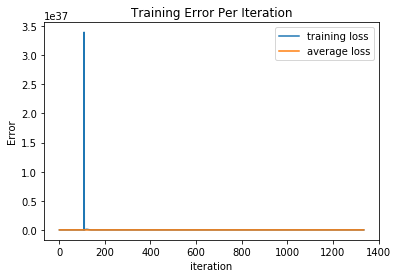

In [205]:
##Plot losses
losses = np.array(losses)
print(losses.shape)
iterations= np.linspace(1,n_max*n_epochs,n_max*n_epochs)
avg_loss = np.average(losses[-n_max:])
print('Average loss per iteration, final epoch: ',avg_loss)
plt.plot(iterations,losses,iterations,avg_loss*np.ones(iterations.shape))
plt.title('Training Error Per Iteration')
plt.ylabel('Error')
plt.xlabel('iteration')
plt.legend(('training loss','average loss'))



Average loss per iteration:  0.36085817


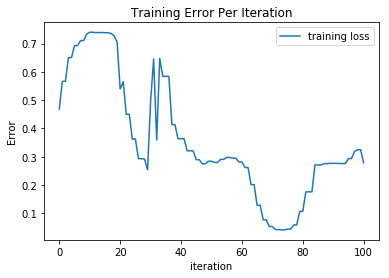

In [206]:
####validation
validation_loss = []
for i in range(n_max-1,samples):
    
    training_var,gtruth_var = get_training(data,img_bbox,i)
    
    outputs = net(training_var)
    #print(gtruth_var,outputs)
    loss = loss_fn(outputs, gtruth_var)
    validation_loss.append(loss.data.numpy())

validation_loss = np.array(validation_loss)
avg_loss = np.average(validation_loss)
print('Average loss per iteration: ',avg_loss)
plt.plot(validation_loss)
plt.title('Training Error Per Iteration')
plt.ylabel('Error')
plt.xlabel('iteration')
plt.legend(('training loss','average loss'))
    
    
    
    
    

In [207]:
## Plotting of result
results = []
for l in range(samples):
    
    training_var,gtruth_var = get_training(data,img_bbox,l)
    outputs = net(training_var)
    results.append(outputs.data.numpy())



[[-1.8223338   0.29389846]
 [-1.8223338   0.29389846]
 [-1.8223338   0.29389846]
 [-1.8223338   0.29389846]
 [-1.8223338   0.29389846]
 [-1.8223338   0.29389846]
 [-1.8223338   0.29389846]
 [-1.8223338   0.29389846]
 [-1.8223338   0.29389846]
 [-1.8223338   0.29389846]]


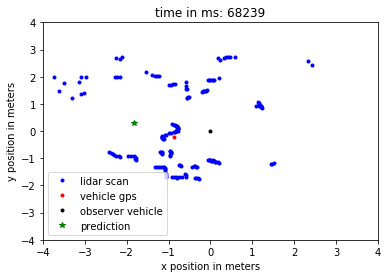

In [210]:
results = np.array(results)
print(results[-10:,:])
#plt.plot(results[-10:,0],results[-10:,1],'*b')
fig = plt.figure()
i = 300
#for i in range(data.shape[0]):
lidar = get_lidar(i,data)
hedge = get_hedge(i,data)
plt.cla()
plt.axis((-4,4,-4,4))
plt.plot(lidar[0],lidar[1],'.b',hedge[0],hedge[1],'.r',0,0,'k.',results[i,0],results[i,1],'*g')
plt.title('time in ms: ' + str(get_timestamp(i,data)))
plt.xlabel('x position in meters')
plt.ylabel('y position in meters')
plt.legend(('lidar scan','vehicle gps','observer vehicle','prediction'),loc=3)
    
   